In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, GRU, Bidirectional, LSTM
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import defaultdict

<h1>1. Подготовка данных</h1>

In [4]:
df = pd.read_csv('twitter_training.csv')

# Renaming columns for clarity
df.columns = ['ID', 'Topic', 'Sentiment', 'Text']

# Checking the distribution of sentiment labels
sentiment_distribution = df['Sentiment'].value_counts()

# Basic text cleaning (more can be done as needed)
df['Text_Clean'] = df['Text'].str.replace("[^a-zA-Z]", " ").str.lower()

# Encoding sentiment labels as 0 and 1
# Assuming 'Positive' is the most common label based on initial observation, let's encode it as 1, the rest as 0
sentiment_mapping = {
    'Negative': 0,
    'Positive': 1,
    'Neutral': 2,
    'Irrelevant': 3
}

# Apply the mapping to your sentiment column to create a new encoded column
df['Sentiment_Encoded'] = df['Sentiment'].map(sentiment_mapping)

df['Text_Clean'] = df['Text_Clean'].astype(str)

# Tokenization
tokenizer = Tokenizer()
print(df['Text_Clean'])
tokenizer.fit_on_texts(df['Text_Clean'])
sequences = tokenizer.texts_to_sequences(df['Text_Clean'])

# Padding sequences to have the same length
max_sequence_length = max(len(x) for x in sequences)
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Preparing labels
labels = df['Sentiment_Encoded'].values

# Splitting the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

sentiment_distribution, max_sequence_length
df['Text_Clean']

0        i am coming to the borders and i will kill you...
1        im getting on borderlands and i will kill you ...
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    just realized that the windows partition of my...
74677    just realized that my mac window partition is ...
74678    just realized the windows partition of my mac ...
74679    just realized between the windows partition of...
74680    just like the windows partition of my mac is l...
Name: Text_Clean, Length: 74681, dtype: object


0        i am coming to the borders and i will kill you...
1        im getting on borderlands and i will kill you ...
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    just realized that the windows partition of my...
74677    just realized that my mac window partition is ...
74678    just realized the windows partition of my mac ...
74679    just realized between the windows partition of...
74680    just like the windows partition of my mac is l...
Name: Text_Clean, Length: 74681, dtype: object

<h1>2. Модель MLP с обучаемым слоем Embedding</h1>

In [5]:
vocab_size = len(tokenizer.word_index) + 1 
embedding_dim = 100 

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(10, activation='relu')) 
model.add(Dense(4, activation='softmax')) 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1867/1867 [==============================] - 75s 40ms/step - loss: 0.9262 - accuracy: 0.6073 - val_loss: 0.5011 - val_accuracy: 0.8140
Epoch 2/10
1867/1867 [==============================] - 74s 40ms/step - loss: 0.2519 - accuracy: 0.9108 - val_loss: 0.3390 - val_accuracy: 0.8764
Epoch 3/10
1867/1867 [==============================] - 77s 41ms/step - loss: 0.1216 - accuracy: 0.9540 - val_loss: 0.3344 - val_accuracy: 0.8844
Epoch 4/10
1867/1867 [==============================] - 75s 40ms/step - loss: 0.0922 - accuracy: 0.9630 - val_loss: 0.3495 - val_accuracy: 0.8840
Epoch 5/10
1867/1867 [==============================] - 72s 39ms/step - loss: 0.0826 - accuracy: 0.9658 - val_loss: 0.3648 - val_accuracy: 0.8835
Epoch 6/10
1867/1867 [==============================] - 71s 38ms/step - loss: 0.0755 - accuracy: 0.9678 - val_loss: 0.3842 - val_accuracy: 0.8826
Epoch 7/10
1867/1867 [==============================] - 74s 39ms/step - loss: 0.0731 - accuracy: 0.9683 - val_loss: 0.4196 -

467/467 [==============================] - 6s 12ms/step


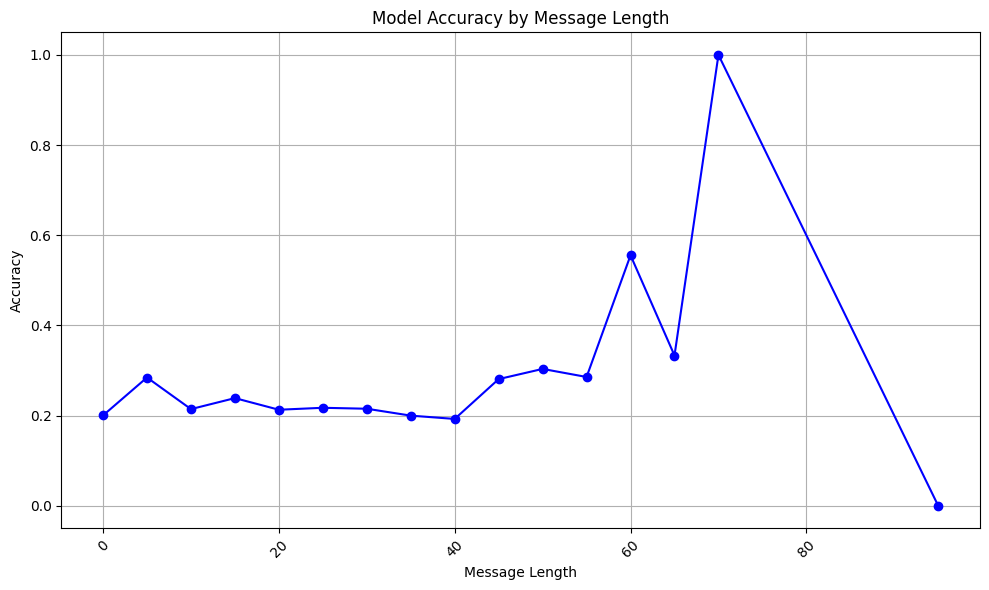

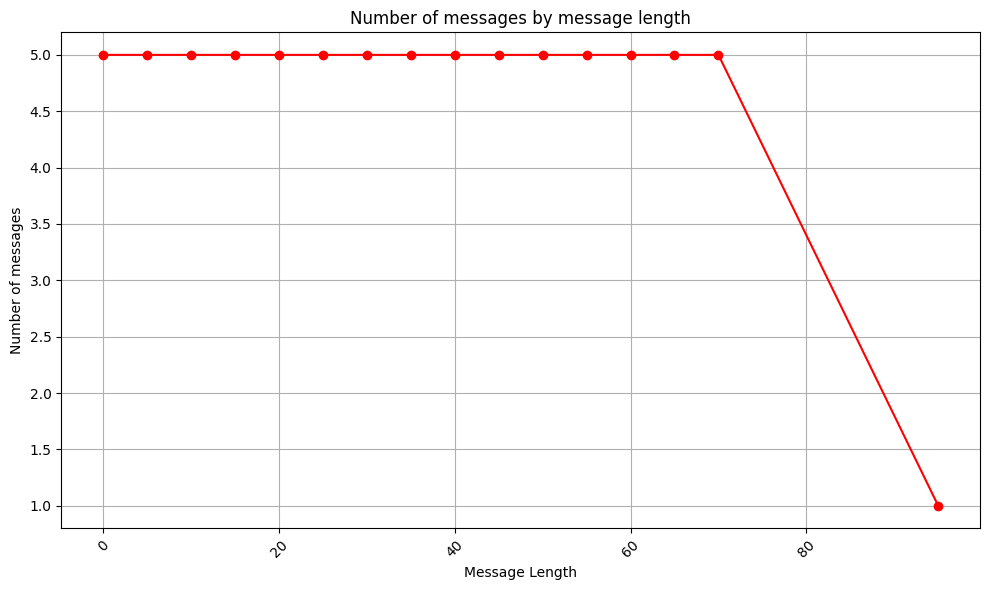

In [20]:
MESSAGES_IN_GROUP = 5
predictions = model.predict(X_val)
def draw_graph(predictions, distribution = False):
    predicted_labels = np.argmax(predictions, axis=1)

    message_lengths = np.count_nonzero(X_val, axis=1)

    unique_lengths = np.unique(message_lengths)
    accuracy_by_length = {}
    number_by_length = {}

    for length in unique_lengths:
        indices = np.where(message_lengths == length)[0]
        actual_labels_for_length = y_val[indices]
        predicted_labels_for_length = predicted_labels[indices]
        
        accuracy = accuracy_score(actual_labels_for_length, predicted_labels_for_length)
        accuracy_by_length[length//MESSAGES_IN_GROUP] = accuracy
        if (number_by_length.get(length//MESSAGES_IN_GROUP)):
            number_by_length[length//MESSAGES_IN_GROUP] += 1
        else:
            number_by_length[length//MESSAGES_IN_GROUP] = 1

    lengths = list(accuracy_by_length.keys())
    accuracies = list(accuracy_by_length.values())
    numbers = list(number_by_length.values())
    plt.figure(figsize=(10, 6))
    plt.plot([length * MESSAGES_IN_GROUP for length in lengths], accuracies, marker='o', linestyle='-', color='b')
    plt.title('Model Accuracy by Message Length')
    plt.xlabel('Message Length')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()  

    if distribution:
        plt.figure(figsize=(10, 6))
        plt.plot([length * MESSAGES_IN_GROUP for length in lengths], numbers, marker='o', linestyle='-', color='r')
        plt.title('Number of messages by message length')
        plt.xlabel('Message Length')
        plt.ylabel('Number of messages')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout() 

        plt.show()

draw_graph(predictions, distribution=True)

<h1>3. Модель MLP с предобученным слоем Embedding (word2Vec, glove или fastText в
зависимости от варианта).</h1>

In [6]:
glove_path = 'glove.twitter.27B.200d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [7]:
model_pretrained = Sequential()

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)
model_pretrained.add(embedding_layer)
model_pretrained.add(Flatten())
model_pretrained.add(Dense(units=64, activation='relu'))
model_pretrained.add(Dense(units=4, activation='softmax')) 

model_pretrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_pretrained.summary()
X_train.shape, X_val.shape, y_train.shape

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 166, 200)          6757000   
                                                                 
 flatten_1 (Flatten)         (None, 33200)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2124864   
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8882124 (33.88 MB)
Trainable params: 2125124 (8.11 MB)
Non-trainable params: 6757000 (25.78 MB)
_________________________________________________________________


((59744, 166), (14937, 166), (59744,))

In [9]:
history = model_pretrained.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


1867/1867 [==============================] - 52s 28ms/step - loss: 1.0229 - accuracy: 0.5838 - val_loss: 0.8883 - val_accuracy: 0.6507
Epoch 2/10
1867/1867 [==============================] - 52s 28ms/step - loss: 0.6454 - accuracy: 0.7573 - val_loss: 0.7840 - val_accuracy: 0.7061
Epoch 3/10
1867/1867 [==============================] - 51s 27ms/step - loss: 0.3871 - accuracy: 0.8588 - val_loss: 0.8123 - val_accuracy: 0.7246
Epoch 4/10
1867/1867 [==============================] - 55s 29ms/step - loss: 0.2465 - accuracy: 0.9099 - val_loss: 0.9121 - val_accuracy: 0.7276
Epoch 5/10
1867/1867 [==============================] - 60s 32ms/step - loss: 0.1864 - accuracy: 0.9324 - val_loss: 1.0450 - val_accuracy: 0.7268
Epoch 6/10
1867/1867 [==============================] - 58s 31ms/step - loss: 0.1535 - accuracy: 0.9426 - val_loss: 1.1542 - val_accuracy: 0.7339
Epoch 7/10
1867/1867 [==============================] - 59s 32ms/step - loss: 0.1349 - accuracy: 0.9478 - val_loss: 1.2622

467/467 [==============================] - 1s 3ms/step


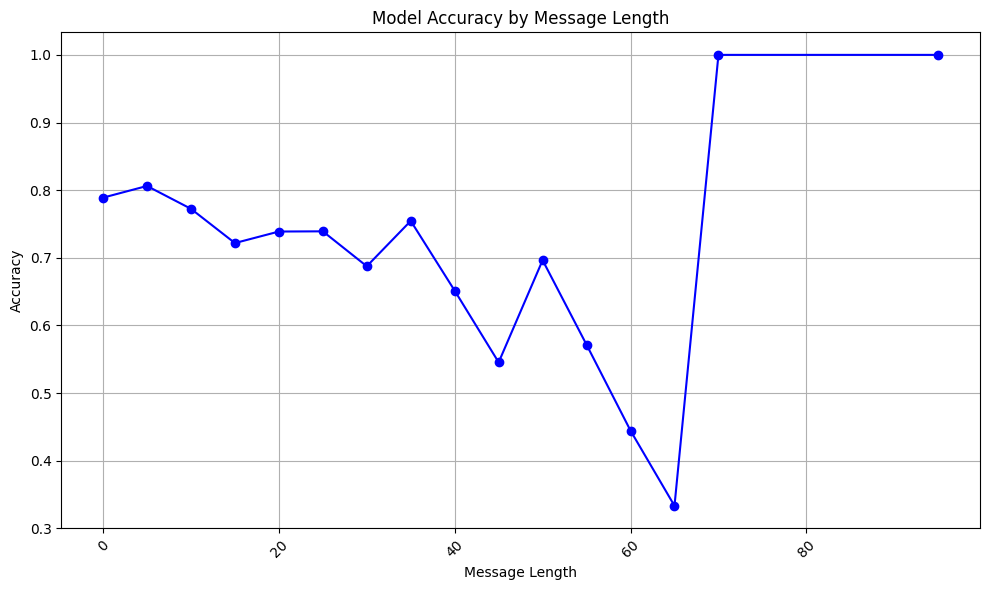

In [21]:
predictions = model_pretrained.predict(X_val)
draw_graph(predictions, distribution=False)

<h3>Как мы видим, вариант с обученным нами слоем оказался более точным.</h3>

<h1>4. Рекуррентная модель со слоем SimpleRnn</h1>

In [17]:
vocab_size = len(tokenizer.word_index) + 1 
embedding_dim = 100

model_simple_RNN = Sequential()
model_simple_RNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_simple_RNN.add(SimpleRNN(64))
model_simple_RNN.add(Dense(4, activation='softmax'))

model_simple_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_simple_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 166, 100)          3378500   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3389320 (12.93 MB)
Trainable params: 3389320 (12.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model_simple_RNN.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1867/1867 [==============================] - 115s 61ms/step - loss: 0.7906 - accuracy: 0.6854 - val_loss: 0.4710 - val_accuracy: 0.8275
Epoch 2/10
1867/1867 [==============================] - 121s 65ms/step - loss: 0.3264 - accuracy: 0.8805 - val_loss: 0.5100 - val_accuracy: 0.8060
Epoch 3/10
1867/1867 [==============================] - 127s 68ms/step - loss: 0.2368 - accuracy: 0.9128 - val_loss: 0.4290 - val_accuracy: 0.8556
Epoch 4/10
1867/1867 [==============================] - 126s 67ms/step - loss: 0.1504 - accuracy: 0.9432 - val_loss: 0.4613 - val_accuracy: 0.8485
Epoch 5/10
1867/1867 [==============================] - 124s 66ms/step - loss: 0.1118 - accuracy: 0.9560 - val_loss: 0.4906 - val_accuracy: 0.8537
Epoch 6/10
1867/1867 [==============================] - 126s 67ms/step - loss: 0.1173 - accuracy: 0.9542 - val_loss: 0.4956 - val_accuracy: 0.8591
Epoch 7/10
1867/1867 [==============================] - 124s 66ms/step - loss: 0.0990 - accuracy: 0.9594 - val_loss: 0

467/467 [==============================] - 6s 12ms/step


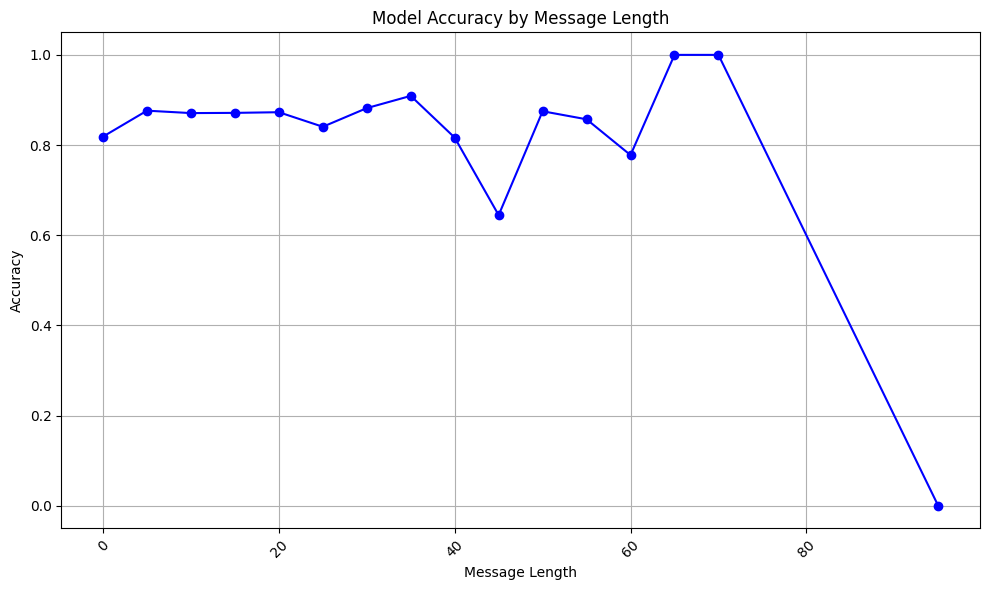

In [22]:
predictions = model_simple_RNN.predict(X_val)
draw_graph(predictions, distribution=False)

<h1>5. Рекуррентная модель со слоем LSTM\GRU</h1>

In [26]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_GRU.add(GRU(64))  # Using a GRU layer with 64 units
model_GRU.add(Dense(4, activation='softmax'))  # Assuming 4 classes for classification

model_GRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model_GRU.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1867/1867 [==============================] - 167s 88ms/step - loss: 0.7738 - accuracy: 0.6928 - val_loss: 0.4589 - val_accuracy: 0.8299
Epoch 2/10
1867/1867 [==============================] - 173s 92ms/step - loss: 0.2937 - accuracy: 0.8913 - val_loss: 0.3523 - val_accuracy: 0.8714
Epoch 3/10
1867/1867 [==============================] - 175s 94ms/step - loss: 0.1861 - accuracy: 0.9293 - val_loss: 0.3385 - val_accuracy: 0.8797
Epoch 4/10
1867/1867 [==============================] - 173s 93ms/step - loss: 0.1444 - accuracy: 0.9435 - val_loss: 0.3294 - val_accuracy: 0.8866
Epoch 5/10
1867/1867 [==============================] - 172s 92ms/step - loss: 0.1195 - accuracy: 0.9519 - val_loss: 0.3555 - val_accuracy: 0.8895
Epoch 6/10
1867/1867 [==============================] - 174s 93ms/step - loss: 0.1050 - accuracy: 0.9563 - val_loss: 0.3693 - val_accuracy: 0.8897
Epoch 7/10
1867/1867 [==============================] - 175s 94ms/step - loss: 0.0945 - accuracy: 0.9602 - val_loss: 0

467/467 [==============================] - 12s 25ms/step


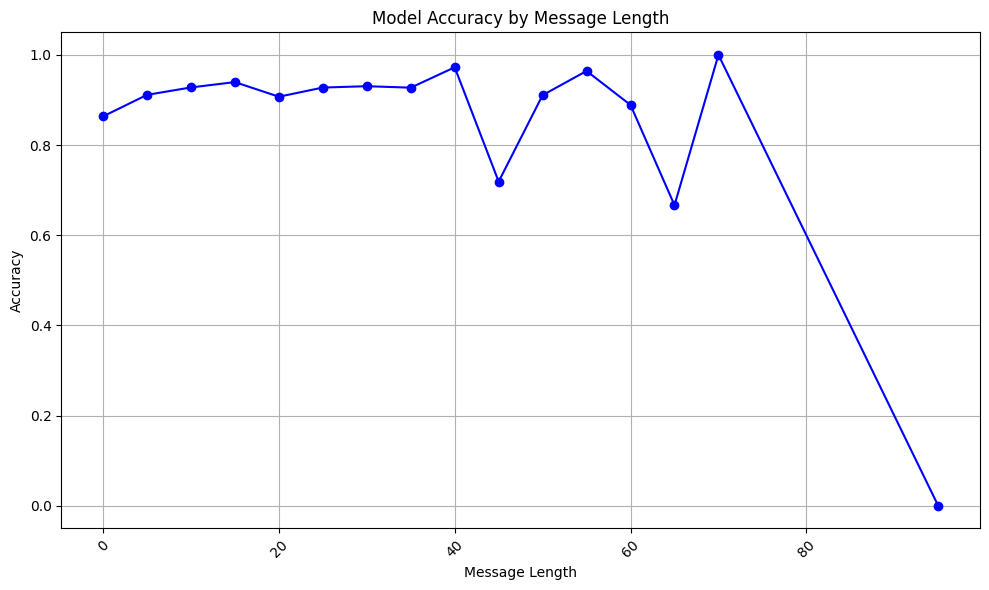

In [28]:
predictions = model_GRU.predict(X_val)
draw_graph(predictions, distribution=False)

<h1>6. Модель по варианту: сверточная модель, двунаправленная рекуррентная сеть, два
рекуррентных слоя (двунаправленная рекуррентная сеть)</h1>

In [32]:
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_bidirectional.add(Bidirectional(LSTM(64)))  # Wrapping LSTM with Bidirectional
model_bidirectional.add(Dense(4, activation='softmax'))  # Assuming 4 classes for classification

model_bidirectional.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model_bidirectional.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1867/1867 [==============================] - 227s 120ms/step - loss: 0.7910 - accuracy: 0.6838 - val_loss: 0.4904 - val_accuracy: 0.8186
Epoch 2/5
1867/1867 [==============================] - 222s 119ms/step - loss: 0.3121 - accuracy: 0.8842 - val_loss: 0.3728 - val_accuracy: 0.8634
Epoch 3/5
1867/1867 [==============================] - 221s 118ms/step - loss: 0.2027 - accuracy: 0.9230 - val_loss: 0.3535 - val_accuracy: 0.8761
Epoch 4/5
1867/1867 [==============================] - 219s 117ms/step - loss: 0.1568 - accuracy: 0.9381 - val_loss: 0.3506 - val_accuracy: 0.8834
Epoch 5/5
1867/1867 [==============================] - 230s 123ms/step - loss: 0.1301 - accuracy: 0.9471 - val_loss: 0.3705 - val_accuracy: 0.8840


467/467 [==============================] - 18s 36ms/step


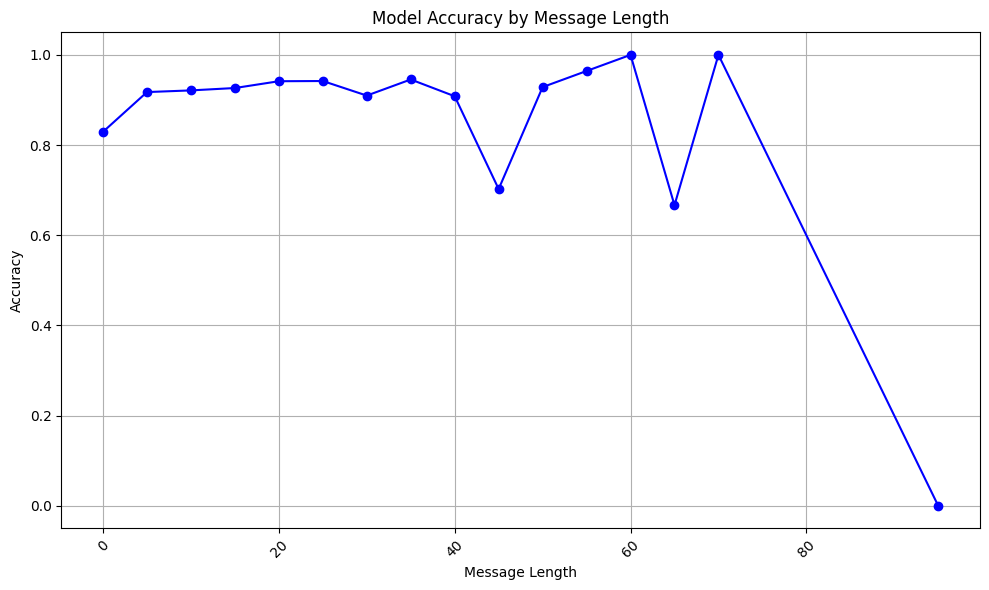

In [34]:
predictions = model_bidirectional.predict(X_val)
draw_graph(predictions, distribution=False)

<h1>7. Провести анализ сходства слов в векторном пространстве.</h1>

In [9]:
class_words = defaultdict(set)  # Use a set to avoid duplicate words within the same class
all_words = set()  # Track all words across classes

for _, row in df.iterrows():
    words = set(list(filter(lambda item: item.isalpha(), row['Text_Clean'].split())))  # Split text into words and create a set to remove duplicates
    class_words[row['Sentiment']].update(words)  # Add words to the set for the class
    all_words.update(words)  # Add words to the set of all words

refined_unique_words_by_class = defaultdict(set)
for class_id, words in class_words.items():
    # Exclude words found in other classes
    unique_words = words.copy()
    for other_class, other_words in class_words.items():
        if class_id != other_class:
            unique_words -= other_words
    refined_unique_words_by_class[class_id] = unique_words

# Convert sets to lists and select a subset if needed
refined_unique_words_by_class = {class_id: list(words) for class_id, words in refined_unique_words_by_class.items()}

# Assuming you want to pick a fixed number of unique words for simplicity
for class_id, words in refined_unique_words_by_class.items():
    refined_unique_words_by_class[class_id] = words[20:30]  # Adjust the number as needed

refined_unique_words_by_class

{'Positive': ['ijqnviwaie',
  'additionnow',
  'longggg',
  'guarantees',
  'nazar',
  'hardfactorwes',
  'ellesmere',
  'cfdutyara',
  'jackpot',
  'jetpacks'],
 'Neutral': ['shave',
  'retweetings',
  'manner',
  'shadesogray',
  'unrest',
  'oion',
  'godfall',
  'makeshift',
  'weeb',
  'heralt'],
 'Negative': ['heirloom',
  'prioritizing',
  'presser',
  'poi',
  'namely',
  'premiums',
  'landiand',
  'hideously',
  'sorta',
  'asshats'],
 'Irrelevant': ['youthful',
  'bites',
  'dismantled',
  'katherine',
  'defensive',
  'jpswitchmania',
  'ksiolajidel',
  'ang',
  'lorenzo',
  'lldevildriver']}

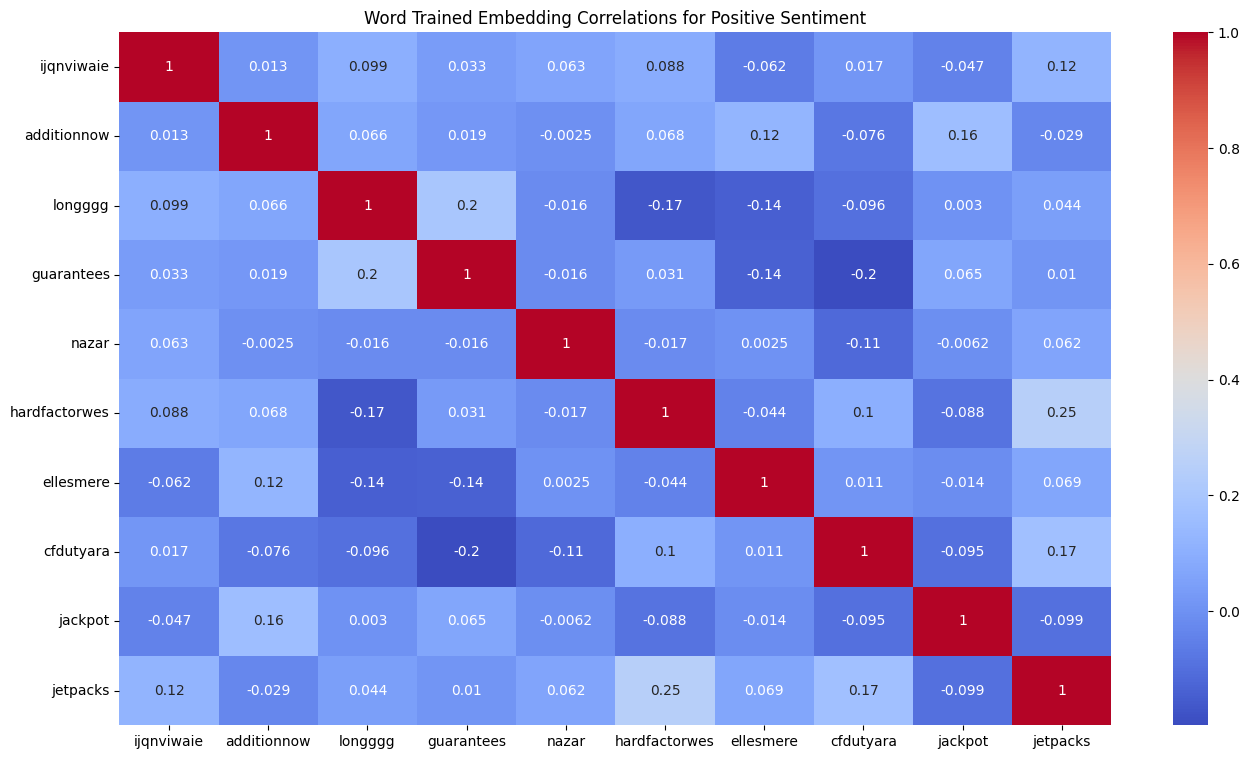

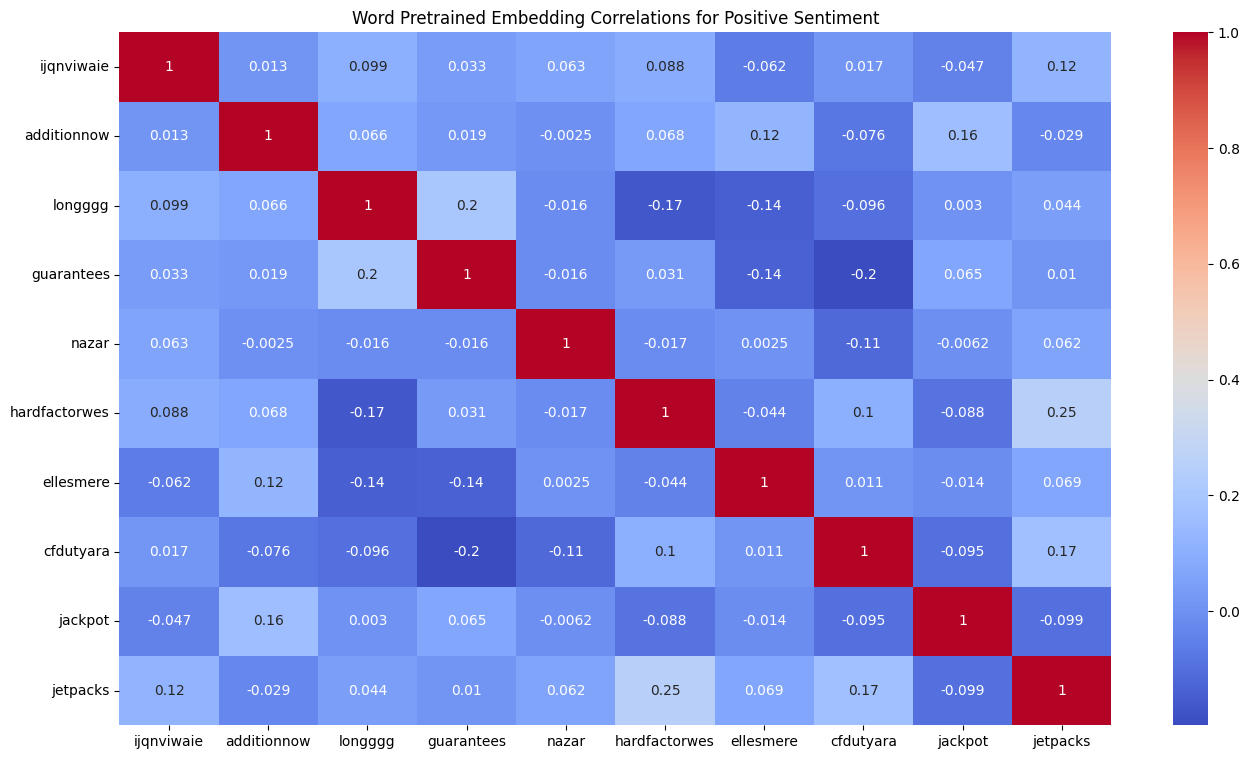

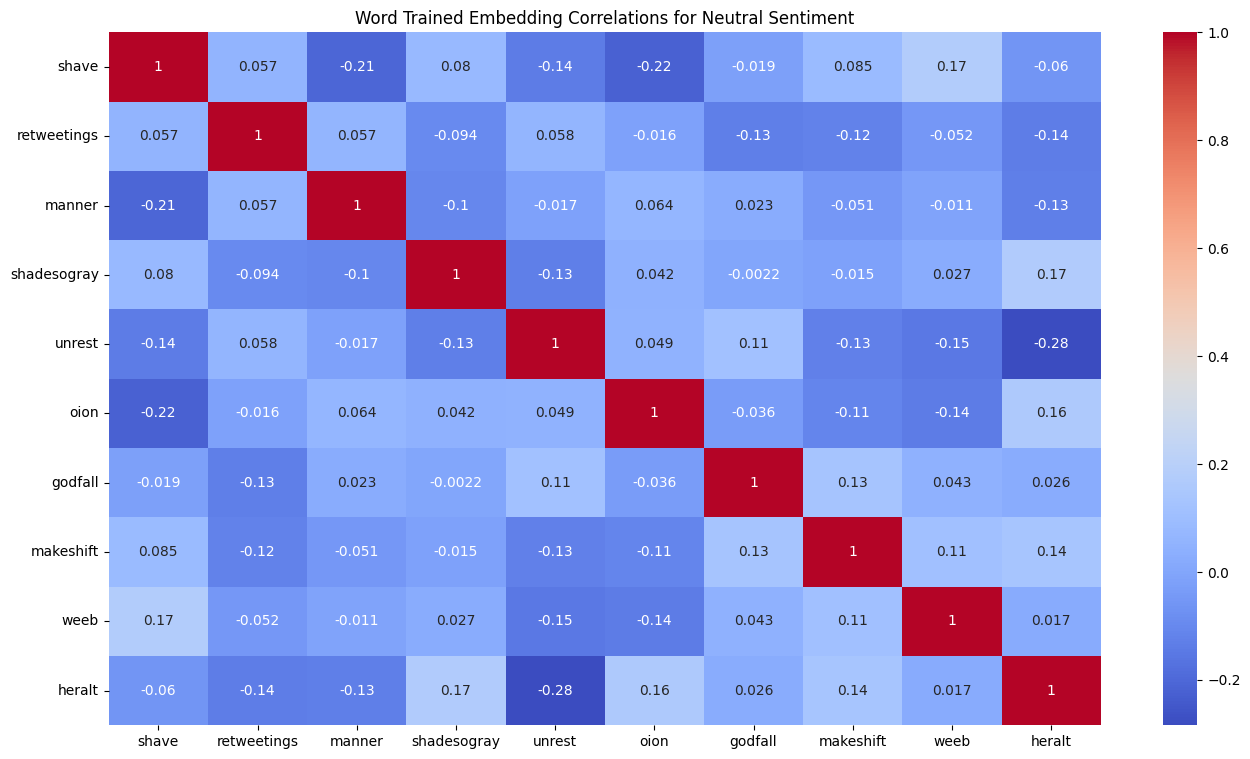

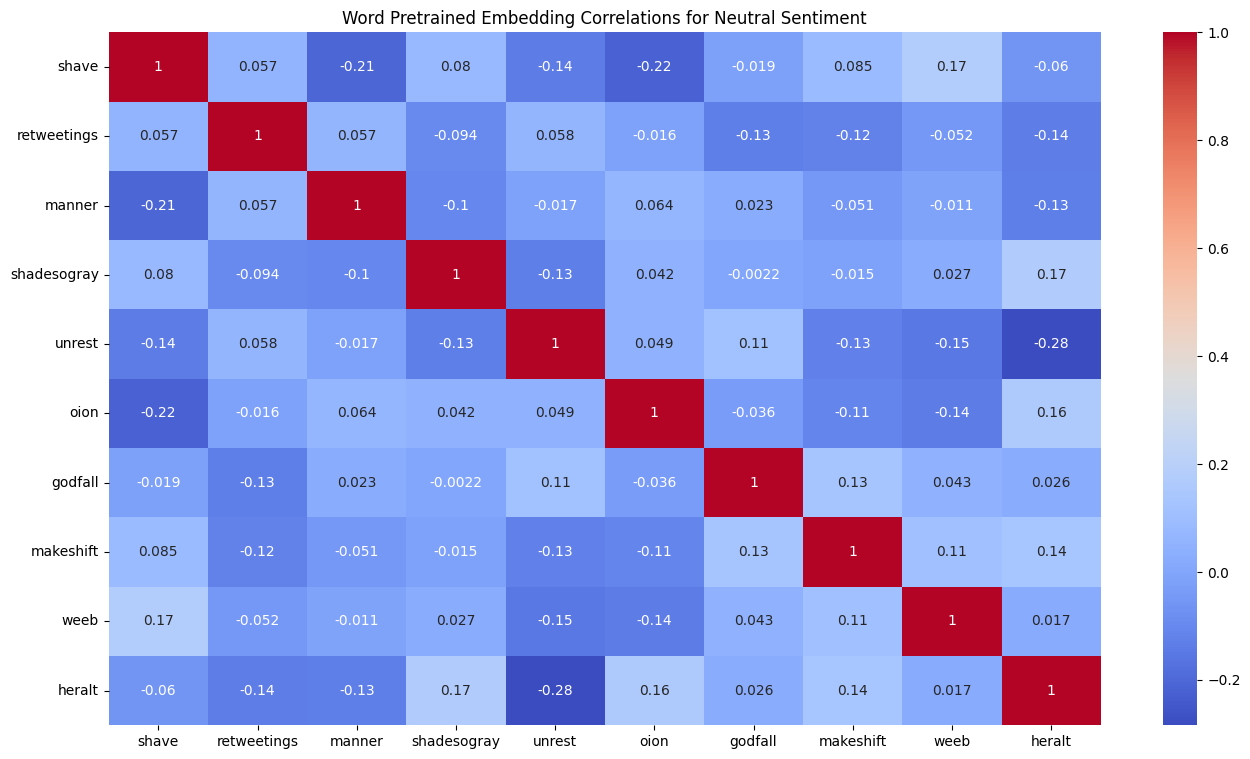

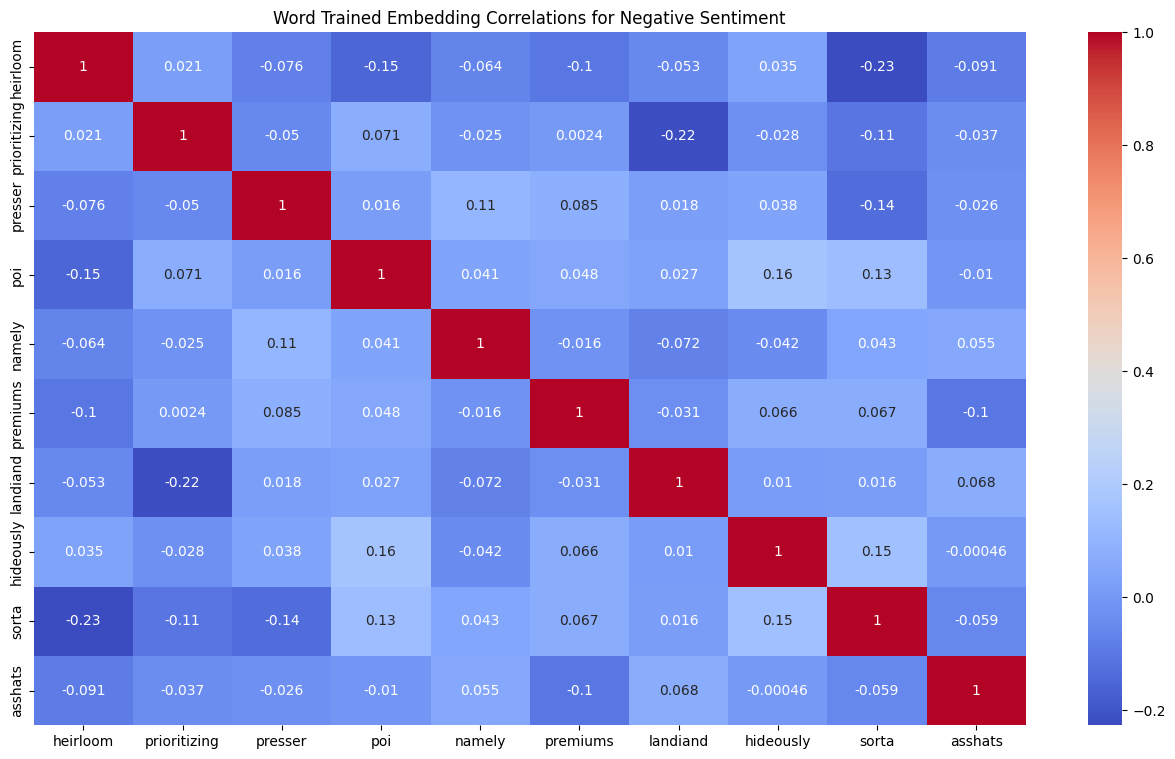

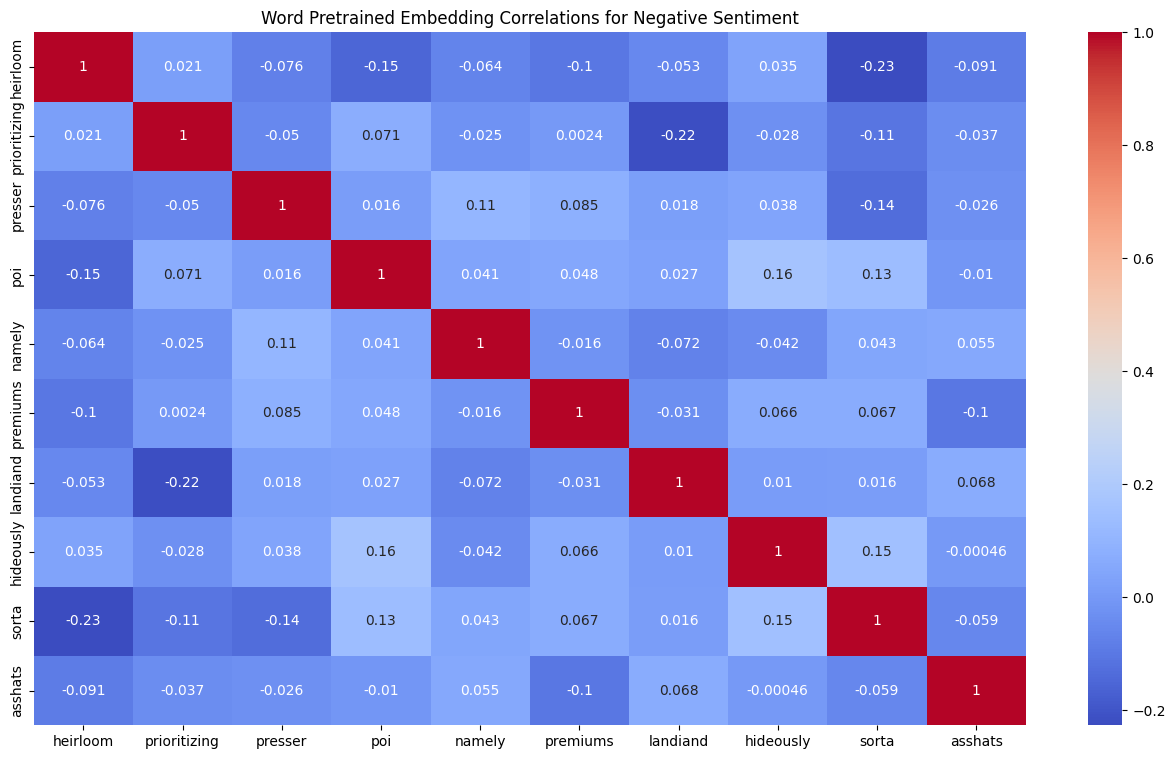

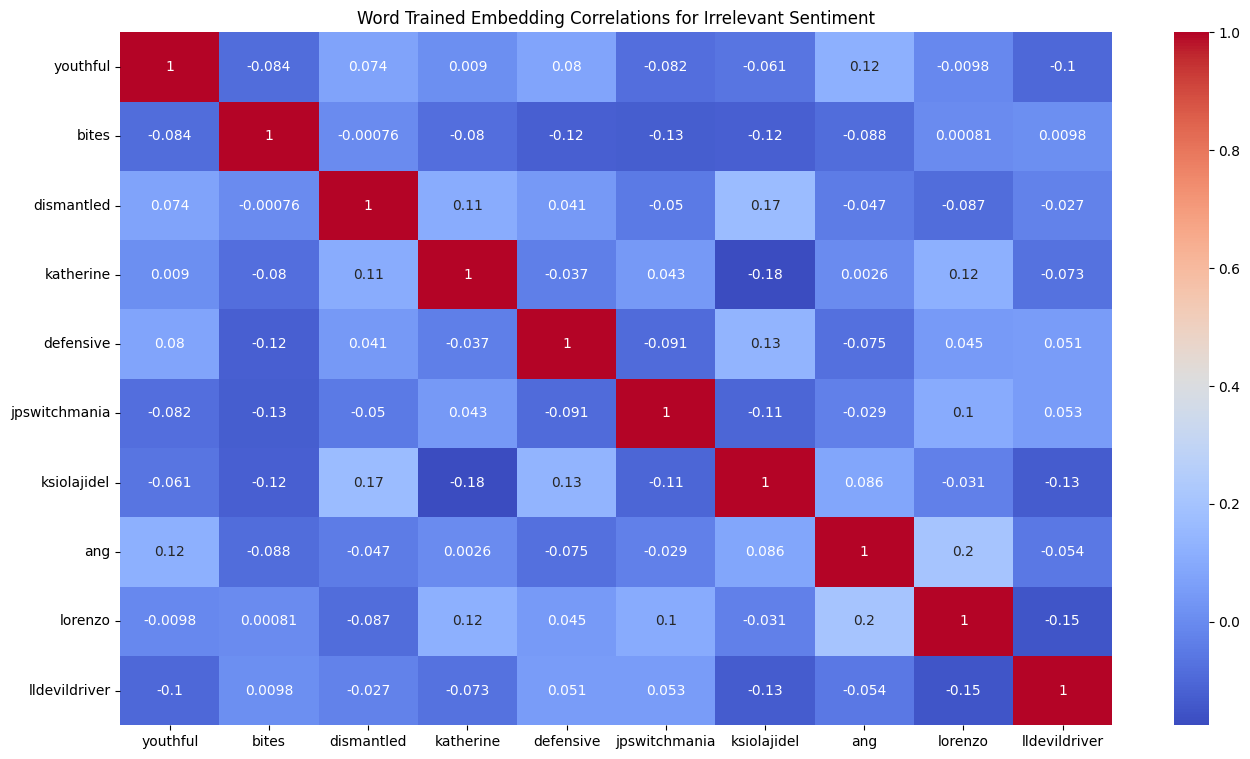

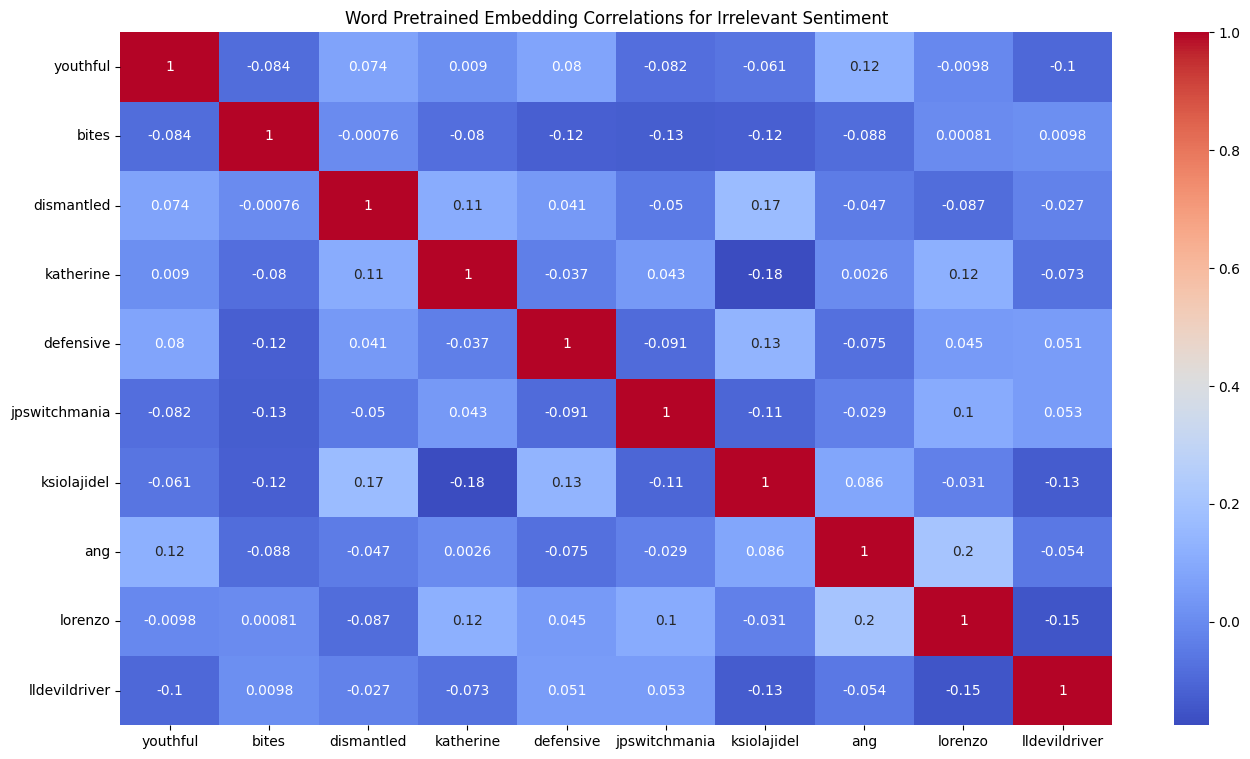

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

trained_embeddings = model.layers[0].get_weights()[0]
non_trained_embeddings = model_pretrained.layers[0].get_weights()[0]

for sentiment, words in refined_unique_words_by_class.items():
    words_in_vocab = [word for word in words if word in tokenizer.word_index]
    selected_vectors = np.array([trained_embeddings[tokenizer.word_index[word]] for word in words_in_vocab])
    selected_vectors_pretrained = np.array([trained_embeddings[tokenizer.word_index[word]] for word in words_in_vocab])
    correlation_matrix = np.corrcoef(selected_vectors)
    correlation_matrix_pretrained = np.corrcoef(selected_vectors_pretrained)
    
    plt.figure(figsize=(16, 9))  # You can adjust the dimensions as needed
    ax = plt.axes()
    sns.heatmap(correlation_matrix, ax=ax, annot=True, cmap='coolwarm', xticklabels=words_in_vocab, yticklabels=words_in_vocab)
    ax.set_title(f'Word Trained Embedding Correlations for {sentiment} Sentiment')
    plt.show()

    plt.figure(figsize=(16, 9))  # You can adjust the dimensions as needed
    ax = plt.axes()
    sns.heatmap(correlation_matrix_pretrained, ax=ax, annot=True, cmap='coolwarm', xticklabels=words_in_vocab, yticklabels=words_in_vocab)
    ax.set_title(f'Word Pretrained Embedding Correlations for {sentiment} Sentiment')
    plt.show()